# Exploratory Data Analysis

## 0. Problem definition

In the supervised regression framework used for this case study, the derivative pricing problem is defined in the regression framework, where the predicted variable is the pricing of the option, and the predictor variables are the market data that are used as inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have; Stock price $S$; Strike price $K$; Risk-free rate $r$; Annual dividend yield $q$; Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year); Volatility $\sigma$

In order to make the logic simpler, we define Moneyness as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$

This simplifes the formula down to the following


$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

**Vol Suface**

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

**Simulation**

In this exercise, we assume the the structure of the vol surface. In practice, we would source the data from a data vendor.
We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$



## 1. Load python packages and data

In [2]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/call-option-pricing/')
import src.settings.base as stg
from src.infrastructure.optionsfunctions import option_vol_from_surface, call_option_price
from src.infrastructure.datageneration import CallData
from src.domain.bestfeatures import show_order_features

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

import warnings
warnings.filterwarnings('ignore')

In [3]:
cd = CallData()
df = cd.data
X = df[stg.FEATURES]
Y = df[stg.TARGET]

## 2. Descriptive Statistics

In [13]:
df.head()

Call Price  Moneyness      Time  Volatility
0    0.501616   0.523739  0.828672    0.305550
1    0.214055   1.012899  0.826726    0.282689
2    0.164418   0.874671  0.277166    0.229287
3    0.207217   1.061477  0.880872    0.288465
4    0.017703   1.403015  0.440955    0.260338

The dataset contains *Call price* -- which is the price of the option and is the predicted variable --
along with *Moneyness* (the ratio of strike and spot price), *Time* (time to maturity), and *Volatility*. which are 
the features of the model.

In [14]:
df.describe()

Call Price     Moneyness          Time    Volatility
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.178322      1.002094      0.504111      0.256847
std        0.136197      0.253701      0.288740      0.030304
min        0.000000      0.036597      0.000540      0.200171
25%        0.073808      0.828604      0.258248      0.231623
50%        0.160115      1.000958      0.506098      0.257046
75%        0.252894      1.172885      0.757442      0.282171
max        0.963756      1.968570      0.999693      0.370469

## 3. Data Visualization

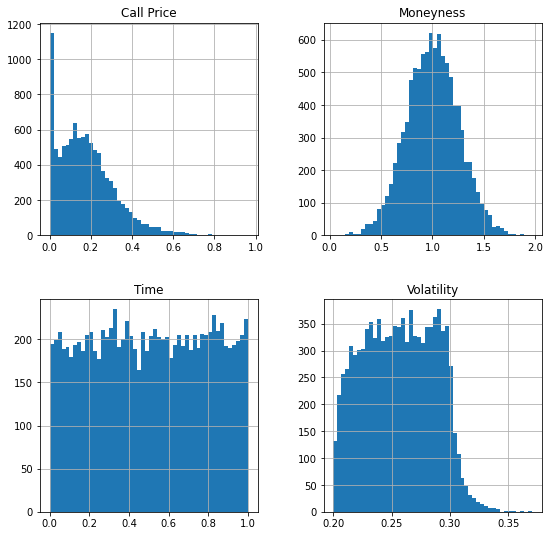

In [15]:
df.hist(bins=50, figsize=(9,9))
plt.show()

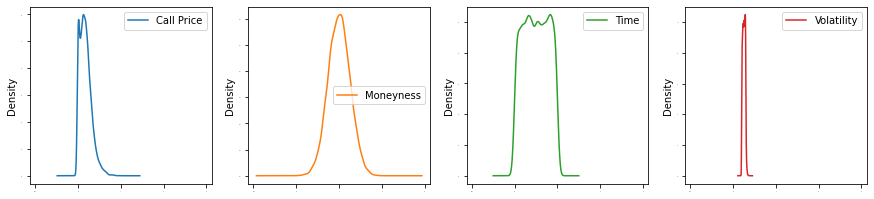

In [16]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

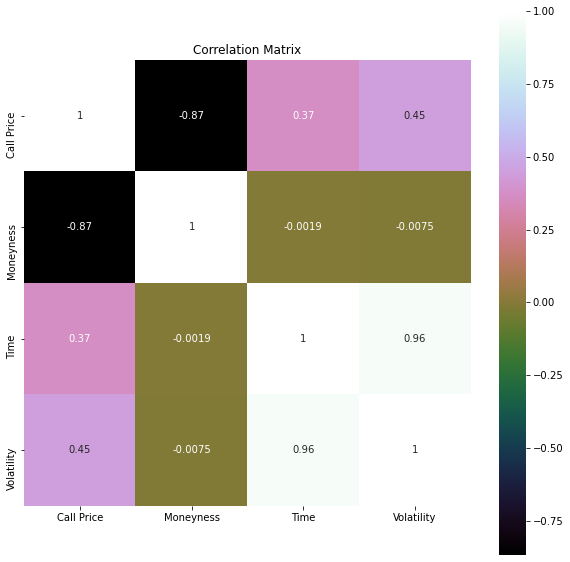

In [4]:
correlation = df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 720x720 with 0 Axes>

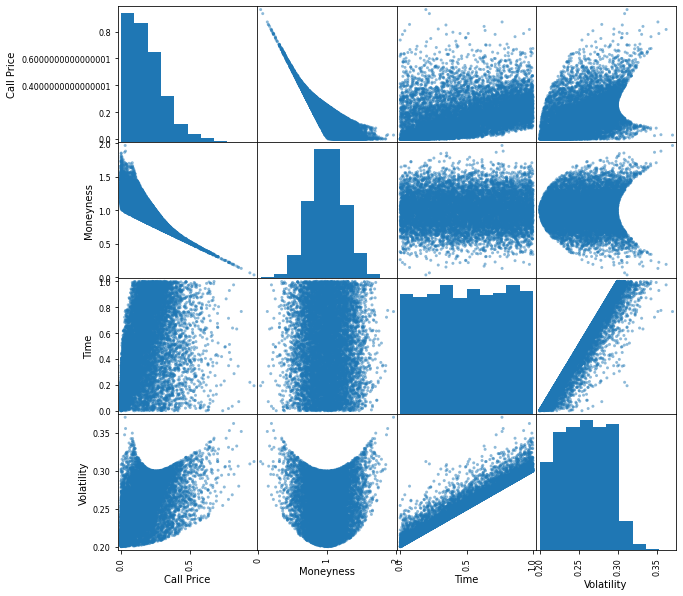

In [18]:
plt.figure(figsize=(10,10))
scatter_matrix(df,figsize=(10,10))
plt.show()

The scatterplot reveals very interesting dependencies and relationships between the variables. Let us look at the first row of the chart to see the relationship of call price to different variables. 

We observe that as moneyness decreases (i.e., strike price decreases as compared to the stock price), thre is an increase in the call price, which is in line with the rational described in the previous section. 

Looking at the call price versus time to maturity, we can see an increase in the option price.

The call price versus volatility chart also shows an increase in the call price with the volatility. 

However, option price seems to exhibit a nonlinear relationship with most of the variables. This means that we expect our nonlinear models to do a better job than our nonlinear models.

Another interesting relationship is between volatility and strike. The more we deviate from the moneyness of one, the higher the volatility we observe. This behavior is shown due to the volatility function we defined before and illustrates the volatility smile/skew.


## 4. Data Preparation and Analysis

### 4.1 Univariate feature selection

In [19]:
show_order_features()

Specs         Score
0   Moneyness  29416.986737
1        Time   1484.199980
2  Volatility   2248.503355

We observe that the moneyness is the most important variable for the option price, followed by volatility and time to maturity.